# Machine learning for control of the initial PSC state

We built a random forest regression model to predict the final differentiation efficiency using the 343 features exrtacted from the bright-field images at the PSC stage. The predicted efficiency correlated well with the true efficiency (**Fig. 5g**), showing that ML can monitor PSC colonies after passage in real-time to identify the most conducive starting point for differentiation. 

In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import matplotlib
from matplotlib import pyplot as plt

from scipy import stats

In [2]:
# Load the dataset.

batch_names = ["CD00-1", "CD00-3", "CD00-4", "CD00-10", "CD00-2", 
               "CD00-6", "CD00-5", "CD00-9", "CD00-8", "CD00-7"]

df_dict = {}

for batch_name in batch_names:
    
    df = pd.read_pickle("./dataset/%s.pkl" % batch_name)
    df_dict[batch_name] = df
        
# Merge the data from each batch

df_all = pd.concat([df_dict[batch_name] for batch_name in batch_names], axis = 0)
df_train = df_all[df_all.train_or_test == "Train"]
df_test = df_all[df_all.train_or_test == "Test"]

In [3]:
# define X and Y

feature_list = ["Area", "Circumference", "Spacing", "Solidity", "Convexity", 
                "Area/Circumference Ratio", "Circularity"]
feature_list.extend(["Cell Brightness",
                    "Local Entropy",
                    "Contrast",
                    "Total Variation",
                 ])
feature_list.extend(["Hu Moment %d" % i for i in range(1, 8)])
feature_list.extend(["SIFT %d" % i for i in range(1, 257)])
feature_list.extend(["ORB %d" % i for i in range(1, 65)])
feature_list.extend(["Max Centroid-Contour Distances", 
                    "Min Centroid-Contour Distances", 
                    "Min/Max Ratio of Centroid-Contour Distances", 
                    "Mean of Centroid-Contour Distances", 
                    "Std of Centroid-Contour Distances", 
                 ])

X_train = df_train.loc[:, feature_list].to_numpy()
y_train = df_train.normalized_efficiency

X_test = df_test.loc[:, feature_list].to_numpy()
y_test = df_test.normalized_efficiency

In [4]:
# define a random forest regression model

regr = Pipeline([("preprocess", StandardScaler()),
                 ("clf", RandomForestRegressor(n_estimators=20, 
                                               max_depth=8, max_features=15, random_state=123))
                ])

# train the model

regr.fit(X_train, y_train)

# obtain the predicion

y_pred = regr.predict(X_test)

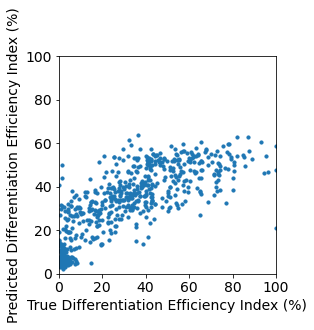

R = 0.759926, p = 0.000000


In [5]:
# correlation analysis

plt.scatter(y_test * 100, 
            y_pred * 100, 
            s = 10)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("True Differentiation Efficiency Index (%)", fontsize = 14)
plt.ylabel("Predicted Differentiation Efficiency Index (%)", fontsize = 14)

plt.xticks([0, 20, 40, 60, 80, 100], fontsize= 14)
plt.yticks([0, 20, 40, 60, 80, 100], fontsize= 14)

plt.gca().set_aspect(1)
plt.show()

r, p = stats.pearsonr(y_test, y_pred)
print("R = %f, p = %f" % (r, p))